# ASHRAE - Great Energy Predictor III


Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

**[Update] I published "[Optuna tutorial for hyperparameter optimization](https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization)" notebook.
Please also check it :)**

In [8]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


In [9]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [10]:
#%%time
root = Path('../data')

train_df = pd.read_csv(root/'train.csv')
weather_train_df = pd.read_csv(root/'weather_train.csv')
building_meta_df = pd.read_csv(root/'building_metadata.csv')



In [11]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
#test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
#weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [12]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [13]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = sns.lineplot(x='date', y='meter_reading_log1p', data=train_temp_df_meter)
    plt.show()

C:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



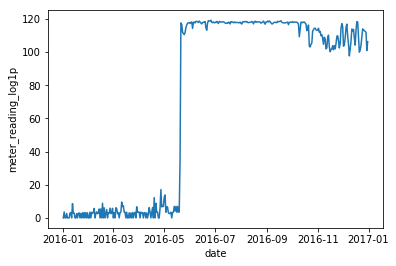

In [14]:
plot_date_usage(train_df, meter=0, building_id=1)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [15]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


In [16]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

In [17]:
debug = False

# Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags

#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [18]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [19]:
preprocess(train_df)

In [20]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

In [21]:
building_mean.head()

building_id
0    5.433594
1    4.761719
2    2.998047
3    5.875000
4    7.343750
Name: meter_reading_log1p, dtype: float16

# Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [22]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [23]:
# weather_train_df.describe()

In [24]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [25]:
weather_train_df.shape

(139773, 9)

In [26]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0
1,0,0,1,7062,1,8763,52,3,0
2,0,0,1,2354,1,66,44,591,5
3,0,0,4,3642,6,37,158,153,4
4,0,0,0,4230,2,1317,73,105,0
5,0,0,2,6030,2,8755,8755,295,3
6,0,0,10,2992,10,0,175,779,39
7,0,0,0,8614,23,7883,8,0,0
8,0,0,3,3830,3,1,85,250,0


In [27]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [28]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,,
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0
6,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [29]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [30]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [31]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [32]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind_direction_max_lag3', 'wind_direction_min_lag3',
       'wind_direction_std_lag3', 'wind_speed_mean_lag3',
       'wind_speed_max_lag

In [33]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


414

In [34]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1857.04 MB
Memory usage after optimization is: 776.94 MB
Decreased by 58.2%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 74.9%
Memory usage of dataframe is 24.53 MB
Memory usage after optimization is: 18.00 MB
Decreased by 26.6%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,air_temperature_mean_lag3,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2016-01-01 00:00:00,25.000000,6.000000,20.000000,-1.0,1019.5,0.0,0.000000,25.000000,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2016-01-01 01:00:00,24.406250,4.000000,21.093750,-1.0,1020.0,70.0,1.500000,24.703125,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2016-01-01 02:00:00,22.796875,2.000000,21.093750,0.0,1020.0,0.0,0.000000,24.062500,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2016-01-01 03:00:00,21.093750,2.000000,20.593750,0.0,1020.0,0.0,0.000000,22.765625,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2016-01-01 04:00:00,20.000000,2.000000,20.000000,-1.0,1020.0,250.0,2.599609,21.296875,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
5,0,2016-01-01 05:00:00,19.406250,4.000000,19.406250,0.0,1019.5,0.0,0.000000,20.171875,...,1019.5,0.231689,53.343750,250.0,0.0,100.31250,0.683105,2.599609,0.0,1.114258
6,0,2016-01-01 06:00:00,21.093750,6.000000,21.093750,-1.0,1019.5,0.0,0.000000,20.171875,...,1019.5,0.305420,45.718750,250.0,0.0,93.81250,0.585938,2.599609,0.0,1.049805
7,0,2016-01-01 07:00:00,21.093750,6.000000,21.093750,0.0,1019.0,210.0,1.500000,20.531250,...,1019.0,0.480957,66.250000,250.0,0.0,104.43750,0.700195,2.599609,0.0,1.024414
8,0,2016-01-01 08:00:00,20.593750,6.000000,20.000000,0.0,1018.0,0.0,0.000000,20.937500,...,1018.0,0.713867,58.875000,250.0,0.0,100.18750,0.622070,2.599609,0.0,0.985840
9,0,2016-01-01 09:00:00,21.093750,6.000000,20.593750,0.0,1019.0,290.0,1.500000,20.937500,...,1018.0,0.697266,82.000000,290.0,0.0,119.43750,0.709961,2.599609,0.0,0.970215


In [35]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [36]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [37]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [38]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [39]:
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

# Train model by each meter type

target_meter 0 (11714696, 34)
cat_features [31, 32, 33]
train 9371756 valid 2342940
training LGB:


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

C:\Anaconda\lib\site-packages\lightgbm\basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.682885	valid_1's l2: 0.722728
[40]	training's l2: 0.413837	valid_1's l2: 0.491009
[60]	training's l2: 0.356232	valid_1's l2: 0.455503
[80]	training's l2: 0.326433	valid_1's l2: 0.449792
[100]	training's l2: 0.296342	valid_1's l2: 0.451115
Early stopping, best iteration is:
[83]	training's l2: 0.321805	valid_1's l2: 0.448816
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.3218049424816931}, 'valid_1': {'l2': 0.44881631310323833}})
train 9371757 valid 2342939
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.708649	valid_1's l2: 0.642231
[40]	training's l2: 0.440971	valid_1's l2: 0.378793
[60]	training's l2: 0.379567	valid_1's l2: 0.330502
[80]	training's l2: 0.346659	valid_1's l2: 0.317821
[100]	training's l2: 0.316838	valid_1's l2: 0.317214
Early stopping, best iteration is:
[93]	training's l2: 0.327555	valid_1's l2: 0.314602
best_score defaul

10

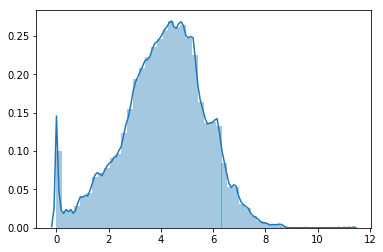

In [40]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

In [41]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

target_meter 1 (4182440, 34)
cat_features [31, 32, 33]
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.4866	valid_1's l2: 2.9251
[40]	training's l2: 1.73052	valid_1's l2: 1.99672
[60]	training's l2: 1.47233	valid_1's l2: 1.79217
[80]	training's l2: 1.34613	valid_1's l2: 1.7279
[100]	training's l2: 1.26633	valid_1's l2: 1.70023
[120]	training's l2: 1.21056	valid_1's l2: 1.6918
[140]	training's l2: 1.16774	valid_1's l2: 1.68702
[160]	training's l2: 1.13166	valid_1's l2: 1.68178
[180]	training's l2: 1.10101	valid_1's l2: 1.67966
Early stopping, best iteration is:
[177]	training's l2: 1.10473	valid_1's l2: 1.67844
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.1047286710215387}, 'valid_1': {'l2': 1.6784414017878015}})
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.46713	valid_1's l2: 2.54603
[40]	training's l2: 1.68781	vali

10

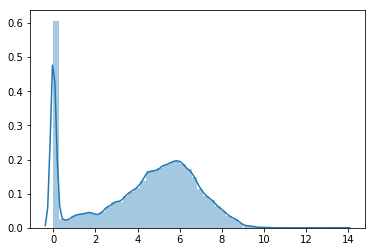

In [42]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 2 (2708713, 34)
cat_features [31, 32, 33]
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.64006	valid_1's l2: 3.2209
[40]	training's l2: 1.90715	valid_1's l2: 2.57471
[60]	training's l2: 1.71351	valid_1's l2: 2.47906
[80]	training's l2: 1.60836	valid_1's l2: 2.45466
[100]	training's l2: 1.53558	valid_1's l2: 2.44897
Early stopping, best iteration is:
[90]	training's l2: 1.56547	valid_1's l2: 2.44646
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5654675847769997}, 'valid_1': {'l2': 2.4464645773421774}})
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.61496	valid_1's l2: 2.95748
[40]	training's l2: 1.85784	valid_1's l2: 2.42993
[60]	training's l2: 1.6583	valid_1's l2: 2.35606
[80]	training's l2: 1.55491	valid_1's l2: 2.32429
[100]	training's l2: 1.49004	valid_1's l2: 2.29272
[120]	training's l2: 1.43996	valid

10

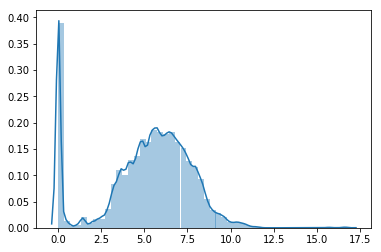

In [43]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

target_meter 3 (1264037, 34)
cat_features [31, 32, 33]
train 1011229 valid 252808
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.54089	valid_1's l2: 4.28154
[40]	training's l2: 2.49496	valid_1's l2: 3.13189
[60]	training's l2: 2.13334	valid_1's l2: 2.69818
[80]	training's l2: 1.98176	valid_1's l2: 2.5272
[100]	training's l2: 1.89034	valid_1's l2: 2.44988
[120]	training's l2: 1.827	valid_1's l2: 2.41335
[140]	training's l2: 1.77526	valid_1's l2: 2.39005
[160]	training's l2: 1.73192	valid_1's l2: 2.37922
[180]	training's l2: 1.69299	valid_1's l2: 2.37157
[200]	training's l2: 1.66288	valid_1's l2: 2.36501
[220]	training's l2: 1.63637	valid_1's l2: 2.3646
[240]	training's l2: 1.61061	valid_1's l2: 2.36168
[260]	training's l2: 1.58498	valid_1's l2: 2.35714
[280]	training's l2: 1.56584	valid_1's l2: 2.35729
Early stopping, best iteration is:
[267]	training's l2: 1.57851	valid_1's l2: 2.35654
best_score defaultdict(<class 'dict'>, {'training'

10

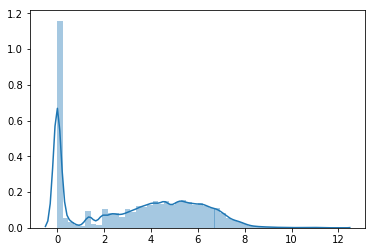

In [44]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

# Prediction on test data

In [45]:
print('loading...')
test_df = pd.read_csv(root/'test.csv')
weather_test_df = pd.read_csv(root/'weather_test.csv')

print('preprocessing building...')
test_df['timestamp']=pd.to_datetime(test_df['timestamp'])
weather_test_df['timestamp']=pd.to_datetime(weather_test_df['timestamp'])
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 3260.81 MB
Memory usage after optimization is: 1232.77 MB
Decreased by 62.2%
Memory usage of dataframe is 48.65 MB
Memory usage after optimization is: 35.69 MB
Decreased by 26.6%


226

In [46]:
sample_submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))
reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.25 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [47]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [48]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += np.expm1(y_pred_test)

    y_test_pred_total /= len(models)
    return y_test_pred_total


iterations 25
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


487

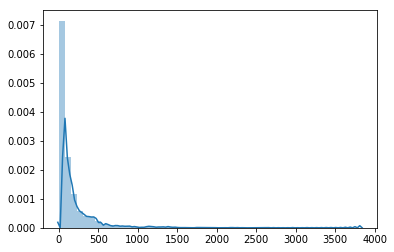

In [54]:
#%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


158

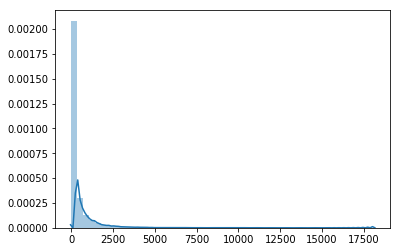

In [55]:
#%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


158

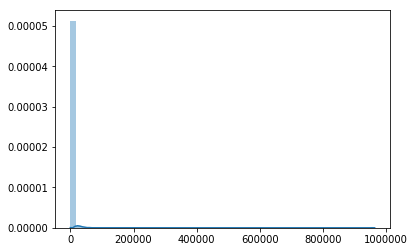

In [56]:
#%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model


298

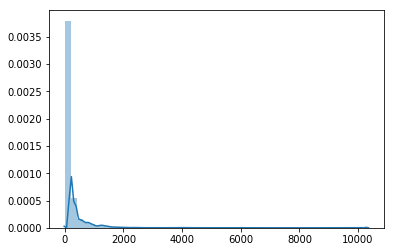

In [57]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [58]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = y_test0
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = y_test1
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = y_test2
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = y_test3

In [59]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [60]:
sample_submission.head()

,row_id,meter_reading
0,0,185.069429
1,1,91.125308
2,2,10.636247
3,3,304.883737
4,4,1359.788581


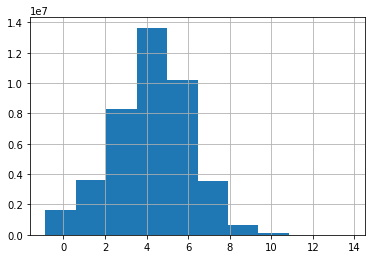

In [61]:
np.log1p(sample_submission['meter_reading']).hist()

C:\Anaconda\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



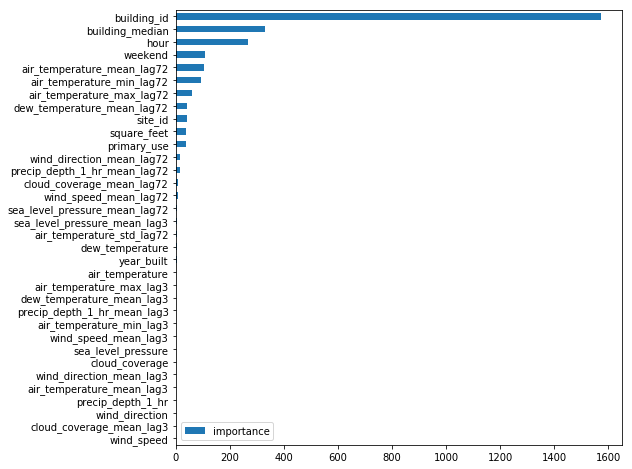

In [62]:
plot_feature_importance(models0[1])

C:\Anaconda\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



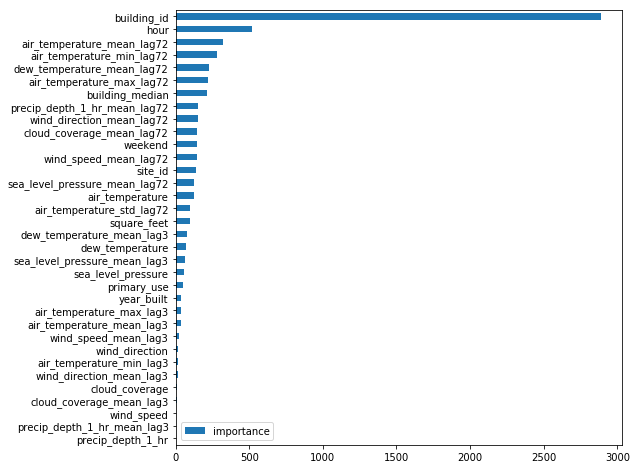

In [63]:
plot_feature_importance(models1[1])

C:\Anaconda\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



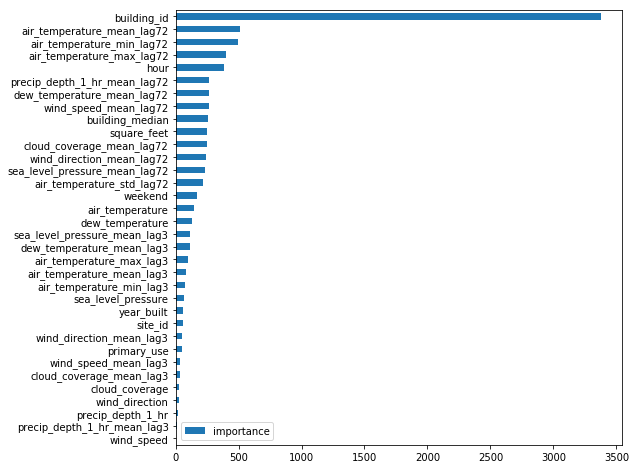

In [64]:
plot_feature_importance(models2[1])

C:\Anaconda\lib\site-packages\matplotlib\figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



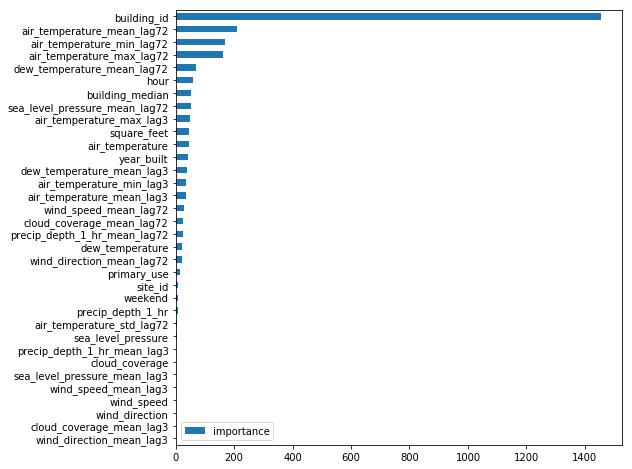

In [65]:
plot_feature_importance(models3[1])

# References

These kernels inspired me to write this kernel, thank you for sharing!

 - https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda
 - https://www.kaggle.com/isaienkov/simple-lightgbm
 - https://www.kaggle.com/ryches/simple-lgbm-solution